# Viscosity estimates for Zebrafish
## Comparison of Pries et al. and Lee et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import exp
from scipy.optimize import brentq

In [2]:
def hd_to_ht(hd, d):
    ht_per_hd = hd + (1 - hd)*(1 + 1.7*exp(-0.415*d) - 0.6*exp(-0.011*d))
    return hd*ht_per_hd

def _ht_to_hd(ht, d, a=0, b=1):
    return brentq(lambda x: hd_to_ht(x, d) - ht, a, b)

def ht_to_hd(ht, d, a=0, b=1):
    ht = np.asarray(ht)
    if ht.ndim == 0:
        return _ht_to_hd(ht.item(), d, a, b)
    
    @np.vectorize
    def comp(ht):
        return _ht_to_hd(ht, d, a, b)
    return comp(ht)

In [3]:
def Pries_mu045(d):
    return 220*exp(-1.3*d) + 3.2 - 2.44*exp(-0.06*(d**0.645))

def Pries_C(d):
    denom = 1 + (10**(-11))*(d**(12))
    factor = 1 / denom
    
    return (0.8 + exp(-0.075*d)) * (-1 + factor) + factor

def Pries_mu_vitro(hd, d):
    C = Pries_C(d)
    mu045 = Pries_mu045(d)
    
    nominator = (1 - hd)**C - 1
    denominator = (1 - 0.45)**C - 1
    factor = nominator / denominator
    
    return 1 + (mu045 - 1)*factor

In [4]:
def lee_mu(ht):
    ht = ht*100
    return 0.0007*ht*ht + 0.0495*ht + 1.5077

In [9]:
lee_mu(.35)

4.097700000000001

## Comparing the curves at d=60µm and d=240µm

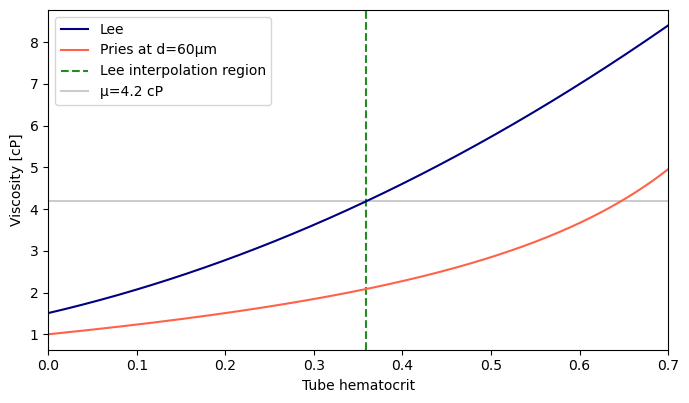

In [257]:
d = 60
ht = np.linspace(0, 0.7, 500)

viscosities_lee = lee_mu(ht)
viscosities_pries = Pries_mu_vitro(ht_to_hd(ht, d), d)


fig, ax = plt.subplots(figsize=(8, 4.5), dpi=100)
ax.plot(ht, viscosities_lee, color="navy", label="Lee")
ax.plot(ht, viscosities_pries, color="tomato", label=f"Pries at d={d}µm")
ax.axvline(.3585, linestyle='--', color='forestgreen', zorder=-1, label="Lee interpolation region")
ax.axhline(4.2, color='k', alpha=0.2, label="µ=4.2 cP", zorder=-2)
ax.set_xlim(0, ht.max())
ax.set_xlabel("Tube hematocrit")
ax.set_ylabel("Viscosity [cP]")
ax.legend()

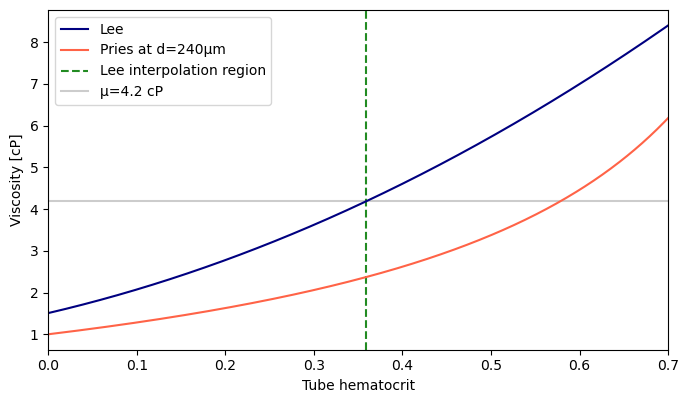

In [258]:
d = 240
ht = np.linspace(0, 0.7, 500)

viscosities_lee = lee_mu(ht)
viscosities_pries = Pries_mu_vitro(ht_to_hd(ht, d), d)


fig, ax = plt.subplots(figsize=(8, 4.5), dpi=100)
ax.plot(ht, viscosities_lee, color="navy", label="Lee")
ax.plot(ht, viscosities_pries, color="tomato", label=f"Pries at d={d}µm")
ax.axvline(.3585, linestyle='--', color='forestgreen', zorder=-1, label="Lee interpolation region")
ax.axhline(4.2, color='k', alpha=0.2, label="µ=4.2 cP", zorder=-2)
ax.set_xlim(0, ht.max())
ax.set_xlabel("Tube hematocrit")
ax.set_ylabel("Viscosity [cP]")
ax.legend()

## Observations
Pries et al. assume that with a hematocrit of 0, we have a viscosity of 1 cP, while for zebrafish, it is actually 1.5 cP. This change alone is not sufficient to make up for the difference though, since the slope of the Lee-estimate is greater than that of the Pries estimate.

## Looking at diameter dependence

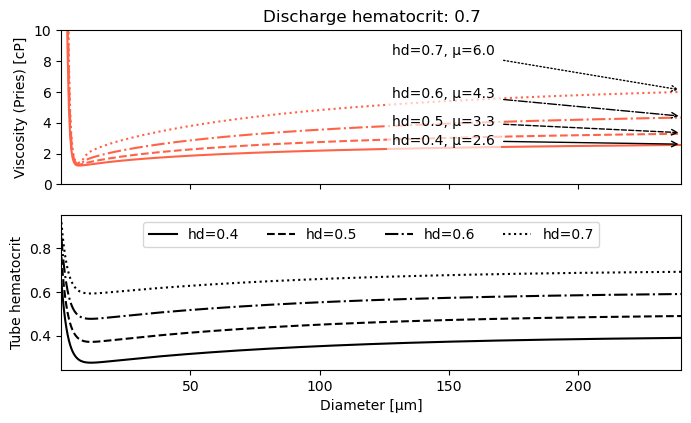

In [273]:
hd_values = [0.4, 0.5, 0.6, 0.7]
linestyles = ['-', '--', '-.', ':']
d = np.linspace(0.1, 240, 500)

fig, axes = plt.subplots(2, 1, figsize=(8, 4.5), dpi=100, sharex=True,)

for hd, linestyle in zip(hd_values, linestyles):
    axes[0,].plot(d, Pries_mu_vitro(hd, d), color="Tomato", linestyle=linestyle)
    axes[1,].plot(d, hd_to_ht(hd, d), color="black", linestyle=linestyle, label=f"hd={hd}")
    axes[0,].set_ylabel("Viscosity (Pries) [cP]")
    end_viscosity = Pries_mu_vitro(hd, d.max())
    axes[0,].annotate(
        f"hd={hd}, µ={end_viscosity:.1f}",
        (d.max(), end_viscosity*1.02),
        (d.max()*0.7, end_viscosity*1.7 - 1.5),
        verticalalignment='center',
        horizontalalignment='right',
        arrowprops={'arrowstyle': '->', 'linestyle': linestyle},
        bbox={'facecolor': '#FFFFFFAA', 'edgecolor': '#00000000'}
    )
    
    axes[1,].set_ylabel("Tube hematocrit")
    axes[1,].set_xlabel("Diameter [µm]")
    axes[0].set_title(f"Discharge hematocrit: {hd}")
    axes[0].set_ylim((0, 10))
    axes[0].set_xlim(d.min(), d.max())
axes[1].legend(ncol=4, loc='upper center',)